In [47]:
from somefunctions import *
from f1_score import *

# Configuration parameters
Easier if we put them all togheter

In [48]:
# Model parameters
pool_size = (2, 2)
train_shape = 400 #size of the training images
patch_size = 16
input_size = 64
pad_size = int(input_size/2 - patch_size/2)


# Training parameters
reg = 1e-6  #regularization term
learning_rate = 0.001
nb_epoch = 40 #very small, only preliminary tests
batch_size = 128
steps_per_epoch = 250 #the number of training samples is huge, arbitrary value


# Data augmentation parameters
FLIP_FLAG = True # add random flips to the patches
ROTATION_FLAG = True # add random rotation to the patches
BRIGHT_CONTRAST_FLAG = True # modify randomly the brightness and the constrast


#Other stuff
NameWeights = 'LeonardoWeigths_0912'
SubmissionName = 'LeonardoSubmission_0912.csv'

# Function to generate the minibatch + data augmentation
This function will be called during the training. <br>

In [49]:
def data_augmentation(X):
    '''Data augmentation on X, element of size (input_size * input_size * 3)'''
    #flip
    if FLIP_FLAG:
        flip_decision = np.random.choice(3)
        if flip_decision == 1:
            X = np.flipud(X)
        if flip_decision == 2: 
            X = np.fliplr(X)
    
    #rotate
    if ROTATION_FLAG:
        number_of_rotations = np.random.choice(3)
        X = np.rot90(X, number_of_rotations)
    
    #contrast and brightness
    if BRIGHT_CONTRAST_FLAG:
        brightness = np.random.rand()*0.3 - 0.15
        contrast = np.random.rand()*0.25 - 0.125
        X = np.clip( X * (contrast/0.5+1) - contrast + brightness, 0, 1)
        
    return X

def generate_minibatch(X,Y):
    """
    Generate a minibatch
    """
    while 1:
        # Generate one minibatch
        X_batch = np.empty((batch_size, input_size, input_size, 3))
        Y_batch = np.empty(batch_size)
        low=input_size//2
        high = (train_shape + 2*pad_size - input_size//2)
        for i in range(batch_size):
            # Select a random image
            idx = np.random.choice(X.shape[0])
            
            x_coord = np.random.randint(low=low, high = high ) 
            y_coord = np.random.randint(low=low, high = high )
      
            X_temp = X[idx,x_coord - input_size//2:x_coord + input_size//2,
                           y_coord - input_size//2:y_coord + input_size//2]
            X_batch[i] = data_augmentation(X_temp)
            
            gt_temp = Y[idx,x_coord - patch_size//2:x_coord + patch_size//2,
                            y_coord - patch_size//2:y_coord + patch_size//2]            
            Y_batch[i] = patch_to_label(gt_temp)
            
        yield X_batch, Y_batch

# Train
Generate the model and train the dataset

In [50]:
# Keep the dropouts with p = 0.5
def create_model():
    '''Create a sequential model'''        
    model = Sequential()
    
    # BLOCK 1: 2 conv + pooling
    model.add(Convolution2D(32, (7,7), 
                            input_shape = ( input_size, input_size, 3),
                            padding = 'SAME' , activation='relu'))
    #model.add(Convolution2D(32, (7,7),
                            #padding = 'SAME' , activation='relu'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))
    
    # BLOCK 2: 2 conv + pooling
    model.add(Convolution2D(64, (5,5), 
                            input_shape = ( input_size, input_size, 3),
                            padding = 'SAME' , activation='relu'))
    #model.add(Convolution2D(64, (5,5),
                            #padding = 'SAME' , activation='relu'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))
    
    # BLOCK 3: 3 conv + pooling
    model.add(Convolution2D(128, (3,3), 
                            input_shape = ( input_size, input_size, 3),
                            padding = 'SAME' , activation='relu'))
    model.add(Convolution2D(128, (3,3),
                            padding = 'SAME' , activation='relu'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))
    
    # Skip the BLOCK 4, otherwise the dimensions are shrinked too much, I think

    # Final BLOCK
    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.5))         
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))       
    model.add(Dense(units = 1, activation = 'sigmoid'))

    #Optimizer          
    opt = Adam(lr=learning_rate) # Adam optimizer with default initial learning rate
 

    # This callback reduces the learning rate when the training accuracy does not improve any more
    lr_callback = ReduceLROnPlateau(monitor='acc', factor=0.5, patience=5,
                                    verbose=1, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)
    
    # Stops the training process upon convergence
    stop_callback = EarlyStopping(monitor='acc', min_delta=0.0001, patience=11, verbose=1, mode='auto')
    
    model.compile(loss=binary_crossentropy,
                  optimizer=opt,
                  metrics=['acc', f1_score])
    
    return model, stop_callback, lr_callback

    

def train(X, Y):    
    '''
    Generate an instance of the model an train the model on X, Y
    '''
    print('Training set shape: ', X.shape) 
    print(f'Batch_size: {batch_size} \nSteps per epoch: {steps_per_epoch} \n')
    
    
    model, stop_callback, lr_callback = create_model()
    
    np.random.seed(20122018) # Reproducibility + remember the deadline is the 20.12.2018
    
    try:
        model.fit_generator(generate_minibatch(X,Y),
                            steps_per_epoch=steps_per_epoch,
                            nb_epoch=nb_epoch,
                            verbose=1,
                            callbacks=[lr_callback, stop_callback])
    except KeyboardInterrupt:
        print('\n\nKeyboard interruption!\n\n')
        pass
    

    model.save_weights(NameWeights)
    
    print(f'Training completed, weights saved in: {NameWeights}')
    
    return model

# Load images

In [51]:
# Load a set of image
root_dir = "../Data/training/"

image_dir = root_dir + "images/"
files = os.listdir(image_dir)
n = len(files) 
print("Loading " + str(n) + " images")
imgs_original = [load_image(image_dir + files[i]) for i in range(n)]
imgs = [load_image(image_dir + files[i]) for i in range(n)]
print(files[0])

gt_dir = root_dir + "groundtruth/"
print("Loading " + str(n) + " images")
gt_imgs = [load_image(gt_dir + files[i]) for i in range(n)]
gt_imgs_not_padded = [load_image(gt_dir + files[i]) for i in range(n)]
print(files[0])

Loading 100 images
satImage_052.png
Loading 100 images
satImage_052.png


# Preprocessing on the whole images

Simply padding

In [52]:
imgs = padding_imgs(np.array(imgs),pad_size)
gt_imgs = padding_GT(np.array(gt_imgs),pad_size)
print(imgs.shape)
print(gt_imgs.shape)

(100, 448, 448, 3)
(100, 448, 448)


# Training

# split in validation + train

(VERY BASIC!) In this way we can check directly what happens in the validation set

In [33]:
# N = imgs.shape[0]
# ratio = 0.8
# N_train = int(N*ratio)
# N_valid = int(N - N*ratio)
# X_train = imgs[:N_train]
# X_valid = imgs[N-N_valid:]
# Y_train = gt_imgs[:N_train]
# print(X_train.shape)
# print(X_valid.shape)
# print(X_train.shape[0] + X_valid.shape[0])
# model = train(X_train,Y_train)

# Since it is very slow, our validation is directly crowdAI, skip the validation part....

In [13]:
X_train = imgs
Y_train = gt_imgs
model = train(X_train,Y_train)

Training set shape:  (100, 448, 448, 3)
Batch_size: 128 
Steps per epoch: 250 



/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:76: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:76: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., steps_per_epoch=250, verbose=1, callbacks=[<keras.ca..., epochs=40)`


Epoch 1/40
250/250 [==============================] - 806s 3s/step - loss: 0.5541 - acc: 0.7403 - f1_score: 0.0117
Epoch 2/40
250/250 [==============================] - 815s 3s/step - loss: 0.4909 - acc: 0.7620 - f1_score: 0.2845
Epoch 3/40
250/250 [==============================] - 773s 3s/step - loss: 0.4297 - acc: 0.8016 - f1_score: 0.4953
Epoch 4/40
250/250 [==============================] - 810s 3s/step - loss: 0.3684 - acc: 0.8377 - f1_score: 0.6273
Epoch 5/40
250/250 [==============================] - 820s 3s/step - loss: 0.3323 - acc: 0.8541 - f1_score: 0.6793
Epoch 6/40
250/250 [==============================] - 809s 3s/step - loss: 0.3161 - acc: 0.8637 - f1_score: 0.7093
Epoch 7/40
250/250 [==============================] - 810s 3s/step - loss: 0.2993 - acc: 0.8710 - f1_score: 0.7270
Epoch 8/40
250/250 [==============================] - 802s 3s/step - loss: 0.2856 - acc: 0.8776 - f1_score: 0.7390
Epoch 9/40
250/250 [==============================] - 801s 3s/step - loss: 0.272

# if we want to go on with the training ...

In [34]:
# X_train = imgs
# Y_train = gt_imgs
# model, lr_callback, stop_callback = create_model()
# model.load_weights('NicolaWeights0612')

# np.random.seed(3) # Reproducibility + remember the deadline is the 20.12.2018
    
# try:
#     model.fit_generator(generate_minibatch(X_train,Y_train),
#                             steps_per_epoch=steps_per_epoch,
#                             nb_epoch=3,
#                             verbose=1,
#                             callbacks=[lr_callback, stop_callback])
# except KeyboardInterrupt:
#     print('\n\nKeyboard interruption!\n\n')
#     pass
# model.save_weights('NicolaWeights2')

# Check if on the train set we have good results

In [53]:
IDX = 1
X = imgs_to_windows(imgs,400,patch_size,input_size)
patches_idx = X[625*IDX:625*(IDX+1)]

print(X.shape)
print(patches_idx.shape)

(62500, 64, 64, 3)
(625, 64, 64, 3)


In [54]:
Z_idx = model.predict(patches_idx)
labels_idx = (Z_idx > 0.5) *1 
print(Z_idx[:3])    

[[5.7939028e-06]
 [2.0689355e-05]
 [1.4416578e-02]]


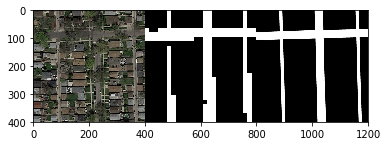

In [55]:
predicted_image = label_to_img(400,400,16,16,labels_idx)
temp = concatenate_images(imgs_original[IDX],predicted_image)
plt.imshow(concatenate_images(temp, gt_imgs_not_padded[IDX]))

# Check what happens on the validation set

In [ ]:
# # Recover the weights without training everything again
# model,_,_ = create_model()
# model.load_weights(NameWeights)

In [ ]:
# #create the input for the model
# val_inputs = imgs_to_windows(X_valid,400,patch_size,input_size)
# print(val_inputs.shape)

In [ ]:
# #get the true value of the labels
# Y_valid = gt_imgs_not_padded[N-N_valid:]
# val_gt_patches = [img_crop(Y_valid[i], patch_size, patch_size) for i in range(N_valid)]
# val_gt_patches =  np.asarray([val_gt_patches[i][j] for i in range(len(val_gt_patches)) for j in range(len(val_gt_patches[i]))])
# val_true_labels = np.asarray([value_to_class(np.mean(val_gt_patches[i])) for i in range(len(val_gt_patches))])
# print(val_true_labels.shape)

In [ ]:
# #predict
# val_prediction = model.predict(val_inputs)
# print(val_prediction[0:3])

In [ ]:
# # compute the metrics
# from sklearn.metrics import f1_score
# val_predicted_labels = ( (val_prediction < 0.5) * 1 ).flatten()
# val_accuracy = np.sum(np.abs(val_predicted_labels - val_true_labels))/val_true_labels.shape[0]
# print('Accuracy on validation set is: ', val_accuracy)
# print('F1 score on validation set is:', f1_score(val_true_labels,val_predicted_labels))

# predict on test

In [56]:
#load images and pad them

test_images = np.asarray(pick_test_images())

test_images = padding_imgs(np.array(test_images),pad_size)

test_images_not_padded = np.asarray(pick_test_images())


In [57]:
#prepare the input for the prediction
test_inputs = imgs_to_windows(test_images,608,patch_size,input_size)
print(test_inputs.shape)

(72200, 64, 64, 3)


In [58]:
#recover the model
model, _,_ = create_model()
model.load_weights(NameWeights)

In [59]:
#predict
test_prediction = model.predict(test_inputs)
print(test_prediction[0:3])

[[0.17985663]
 [0.998024  ]
 [0.99994564]]


In [219]:
test_predicted_labels = ( (test_prediction > 0.5) * 1 ).flatten()
test_labels = test_predicted_labels.reshape(50,-1)
print('Every row contains the labels of one image')
print(test_labels.shape)

Every row contains the labels of one image
(50, 1444)


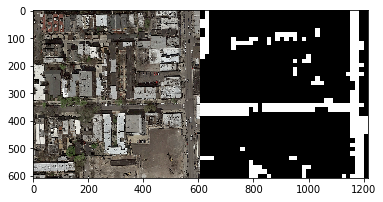

In [220]:
#check the prediction on the image IDX
IDX = 23
im = label_to_img(608, 608, 16, 16, test_labels[IDX])
plt.imshow(concatenate_images(test_images_not_padded[IDX], im))

In [160]:
MY_masks_to_submission(SubmissionName, test_labels)

# Trying Post-Processing

In [ ]:
def post_process(predicted_image,nbr_patches):

    for row in range(1,nbr_of_patches-1):
        for col in range (1,nbr_of_patches-1): 

            # Looking at the label of my_patch's neighbors
            nghb_left = predicted_image[col,row-1];
            nghb_right = predicted_image[col,row+1];
            nghb_up = predicted_image[col-1,row];
            nghb_down = predicted_image[col+1,row];
            nghb_up_left = predicted_image[col-1,row-1];
            nghb_up_right = predicted_image[col-1,row+1];
            nghb_down_left = predicted_image[col+1,row-1];
            nghb_down_right = predicted_image[col+1,row+1];

            # There are 8 neighbors for patches not on the border
            neighbors = [nghb_left,nghb_right,nghb_up,nghb_down,nghb_up_left,nghb_up_right,nghb_down_left,nghb_down_right]

            nbr_labels_street_nghb = sum(neighbors)
            nbr_labels_background_nghb = 8-sum(neighbors)

            is_horizontal_street = (nghb_left == nghb_right == 1)
            is_vertical_street = (nghb_up == nghb_down ==1 )
            is_diagonal_street_1 = (nghb_up_left == nghb_down_right ==1)
            is_diagonal_street_1 = (nghb_up_right == nghb_down_left ==1)

            is_street = (is_horizontal_street or is_vertical_street or is_diagonal_street_1 or is_diagonal_street_1)

            # If a black patch is sourrounded by many white patches it becomes white
            if (nbr_labels_street_nghb >= 5 or is_street):
                predicted_image[row,col] = 1

            # If a white patch is sourrounded by many black patches it becomes black  
            if (nbr_labels_background_nghb >= 6 and not(is_street)):
                predicted_image[row,col] = 0
    return 


In [221]:
def post_process(test_predicted_labels):
    test_labels_images = test_predicted_labels.reshape(50,38,38)
    nbr_of_patches = (test_labels_images.shape)[2]
    
    for im in range(0,(test_labels.shape)[0]): 
        # We start at 1  and finish at nbr_of_patches -1 in order to avoid borders
        #print('Nbr of image being processed = ', im)
        for row in range(1,nbr_of_patches-1):
            for col in range (1,nbr_of_patches-1): 

                # Looking at the label of my_patch's neighbors
                nghb_left = test_labels_images[im,col,row-1];
                nghb_right = test_labels_images[im,col,row+1];
                nghb_up = test_labels_images[im,col-1,row];
                nghb_down = test_labels_images[im,col+1,row];
                nghb_up_left = test_labels_images[im,col-1,row-1];
                nghb_up_right = test_labels_images[im,col-1,row+1];
                nghb_down_left = test_labels_images[im,col+1,row-1];
                nghb_down_right = test_labels_images[im,col+1,row+1];

                # There are 8 neighbors for patches not on the border
                neighbors = [nghb_left,nghb_right,nghb_up,nghb_down,nghb_up_left,nghb_up_right,nghb_down_left,nghb_down_right]
                
                nbr_labels_street_nghb = sum(neighbors)
                nbr_labels_background_nghb = 8-sum(neighbors)

                is_horizontal_street = (nghb_left == nghb_right == 1)
                is_vertical_street = (nghb_up == nghb_down ==1 )
                is_diagonal_street_1 = (nghb_up_left == nghb_down_right ==1)
                is_diagonal_street_1 = (nghb_up_right == nghb_down_left ==1)
                
                is_street = (is_horizontal_street or is_vertical_street or is_diagonal_street_1 or is_diagonal_street_1)
                
                # If a black patch is sourrounded by many white patches it becomes white
                if (nbr_labels_street_nghb >= 5 or is_street):
                    test_labels_images[im,row,col] = 1

                # If a white patch is sourrounded by many black patches it becomes black  
                if (nbr_labels_background_nghb >= 6 and not(is_street)):
                    test_labels_images[im,row,col] = 0
                     
        
        # TREATING THE BORDERS
        for row in range(0,nbr_of_patches-1):
            # right border 
            # Looking at the label of my_patch's neighbors
            nghb_up = test_labels_images[im,0,row-1];
            nghb_up_right = test_labels_images[im,1,row-1];
            nghb_right = test_labels_images[im,1,row];
            nghb_down_right = test_labels_images[im,1,row+1];
            nghb_down = test_labels_images[im,0,row+1];
            
            neighbors = [nghb_up,nghb_up_right,nghb_right,nghb_down_right,nghb_down]
            street_neighbors = nghb_down
            background_neighbors = 5-street_neighbors;
            
            if (street_neighbors > 2):
                test_labels_images[im,0,row] = 1
            if (background_neighbors > 2):
                test_labels_images[im,0,row] = 0
                
        for row in range(0,nbr_of_patches-1):
            # left border 
            # Looking at the label of my_patch's neighbors
            nghb_up = test_labels_images[im,37,row-1];
            nghb_up_left = test_labels_images[im,36,row-1];
            nghb_left = test_labels_images[im,36,row];
            nghb_down_left = test_labels_images[im,36,row+1];
            nghb_down = test_labels_images[im,37,row+1];
            
            neighbors = [nghb_up,nghb_up_right,nghb_right,nghb_down_right,nghb_down]
            street_neighbors = nghb_down
            background_neighbors = 5-street_neighbors;
            
            if (street_neighbors > 2):
                test_labels_images[im,37,row] = 1
            if (background_neighbors > 2):
                test_labels_images[im,37,row] = 0
                
        for col in range(0,nbr_of_patches-1):
            # upper border 
            # Looking at the label of my_patch's neighbors
            nghb_left = test_labels_images[im,col-1,0];
            nghb_down_left = test_labels_images[im,col-1,1];
            nghb_down = test_labels_images[im,col,1];
            nghb_down_right = test_labels_images[im,col+1,1];
            nghb_right = test_labels_images[im,col+1,0];
            
            neighbors = [nghb_up,nghb_up_right,nghb_right,nghb_down_right,nghb_down]
            street_neighbors = nghb_down
            background_neighbors = 5-street_neighbors;
            
            if (street_neighbors > 2):
                test_labels_images[im,col,0] = 1
            if (background_neighbors > 2):
                test_labels_images[im,col,0] = 0
                
        for col in range(0,nbr_of_patches-1):
            # lower border 
            # Looking at the label of my_patch's neighbors
            nghb_left = test_labels_images[im,col-1,37];
            nghb_up_left = test_labels_images[im,col-1,36];
            nghb_up = test_labels_images[im,col,36];
            nghb_up_right = test_labels_images[im,col+1,36];
            nghb_right = test_labels_images[im,col+1,37];
            
            neighbors = [nghb_up,nghb_up_right,nghb_right,nghb_down_right,nghb_down]
            street_neighbors = nghb_down
            background_neighbors = 5-street_neighbors;
            
            if (street_neighbors > 2):
                test_labels_images[im,col,37] = 1
            if (background_neighbors > 2):
                test_labels_images[im,col,37] = 0
        
        
        nbr_street_patches_vertical_right_bord_percent = sum(test_labels_images[im,0,:])/nbr_of_patches
        nbr_street_patches_horizontal_up_bord_percent = sum(test_labels_images[im,:,0])/nbr_of_patches
        nbr_street_patches_vertical_left_bord_percent = sum(test_labels_images[im,37,:])/nbr_of_patches
        nbr_street_patches_horizontal_down_bord_percent = sum(test_labels_images[im,:,37])/nbr_of_patches
        
        if (nbr_street_patches_vertical_right_bord_percent > 0.65):
            test_labels_images[im,0,:] = 1
                        
        if (nbr_street_patches_horizontal_up_bord_percent > 0.65):
            test_labels_images[im,:,0] = 1
            
        if (nbr_street_patches_vertical_left_bord_percent > 0.65):
            test_labels_images[im,37,:] = 1
                        
        if (nbr_street_patches_horizontal_down_bord_percent > 0.65):
            test_labels_images[im,:,37] = 1   
                  
    return test_labels_images.reshape(50,-1)

In [222]:
test_labels_post_processed = post_process(test_predicted_labels)
print(test_labels_post_processed.shape)
                    

(50, 1444)


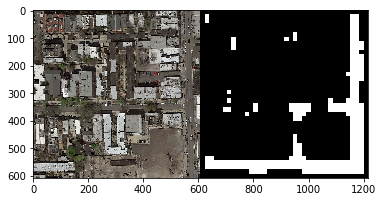

In [223]:
#check the prediction on the image IDX
IDX = 23
im_post = label_to_img(608, 608, 16, 16, test_labels_post_processed[IDX])
plt.imshow(concatenate_images(test_images_not_padded[IDX], im_post))

In [111]:
MY_masks_to_submission('LeonardoSubmission_0912_PP.csv', test_labels_post_processed)